In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import seaborn as sns

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt

# pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

#### Feature engineering

In [5]:
# train = train[train['SalePrice'] <= train['SalePrice'].quantile(0.95)]
# mutual information//cov(x,y)//feed-forward : linear regression

train['SalePrice'] = train['SalePrice'].transform(lambda x:np.log(x))

#### Add features

In [6]:
train['RecordingDate'] = pd.to_datetime(train['RecordingDate'])
train['RecordMonth'] = train['RecordingDate'].map(lambda x: x.month).astype('float64')
train['RecordYear'] = train['RecordingDate'].map(lambda x: x.year).astype('float64')
# train['Year-Month'] = train['RecordingDate'].map(lambda x: str(x.year)+"-"+str(x.month))


In [7]:
train = train.drop('RecordID', axis=1)
train = train.drop('RecordingDate', axis=1)
train.head(3)

,HouseID,SalePrice,PropertyAddressCity,PropertyAddressState,PropertyAddressZIP,CombinedStatisticalArea,CBSAName,CBSACode,MSAName,MSACode,...,StableFlag,StorageBuildingArea,StorageBuildingFlag,UtilityBuildingArea,UtilityBuildingFlag,PoleStructureArea,PoleStructureFlag,CommunityRecRoomFlag,RecordMonth,RecordYear
0,249312309,12.721886,PIRU,CA,93040.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,8.0,2020.0
1,222693201,13.345507,FILLMORE,CA,93015.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,6.0,2017.0
2,222693201,13.592367,FILLMORE,CA,93015.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,2.0,2020.0


#### House Price Distribution
Let's have a look at how the house prices are distributed.

count    475351.000000
mean         12.644425
std           0.845330
min           9.212438
25%          12.198519
50%          12.652360
75%          13.151922
max          21.421401
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Density'>

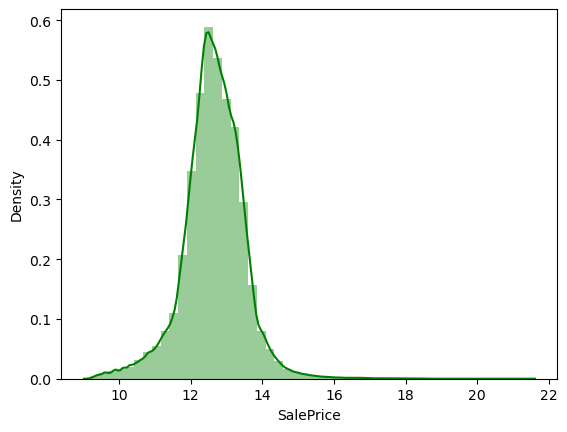

In [8]:
print(train['SalePrice'].describe())
sns.distplot(train['SalePrice'], color='g',hist_kws={'alpha':0.4})

In [9]:
# sns.distplot(train['sqr2_SalePrice'], color='g',hist_kws={'alpha':0.4})

We can see there are a few houses with super high prices. Let ignore them for more informative price distirbution.

In [10]:
# thre = train['SalePrice'].quantile(0.95)
# sns.distplot(train[train['SalePrice']<=thre]['SalePrice'], color='g',bins=100, hist_kws={'alpha':0.4})

#### Numerical Data Distribution

#### Exclude variables:

float64 or int64: 

* There is no variance.
* The number of nan >= half sample size

categorical:

* Some numerical variables should be classified as categorical variables (ex: xxxCODE, xxxFLAG)
* The number of levels <= 1



In [11]:
# # change var ending with CODE, FLAG as object dtype
# for col in train.columns:
#     if col[-4:] in ['Code','Flag']:
#         train[col] = train[col].astype('object')
        
# summary = train.describe().T
# row_nan = train.apply(lambda x: np.sum(x.isna())).T
# cat = train.dtypes.to_frame(name='dtype')

# summary = summary.merge(cat, how='left', left_index=True, right_index=True)
# summary = summary.merge(row_nan.to_frame(name='num_na'), how='left',left_index=True, right_index=True)
# summary.sort_values(['num_na','std'], ascending=[False, True],inplace=True)

# # exclude poor numerical vars
# exclude_vars = summary[(summary['dtype'].isin(['int64','float64'])) 
#                        & ((summary['std']== 0) | (summary['num_na'] >= len(train)//2))]
# mask = ~summary.index.isin(exclude_vars.index.values)
# summary = summary[mask].sort_values('num_na')
# num_vars = list(summary.index.values)

# # summarize categorical variables
# cat_vars = cat[cat['dtype'] == 'object']
# df = pd.DataFrame(columns=['Variable','Level','Count', 'Number of Levels'])

# for col in cat_vars.index.values:
#     num_levels = train[col].nunique()
#     levels = train[col].unique()
    
#     tmp = list(train[col].values)
#     for level in levels:
#         count = tmp.count(level)
#         df = df.append({'Variable': col, 'Level': level,'Count':count, 'Number of Levels': num_levels}, ignore_index=True)

# df.to_csv('train_cat_summary.csv')

# # exclude poor categorical vars
# exclude_vars = df[df['Number of Levels']<=1]['Variable'].unique()
# cat_vars = [i for i in cat_vars.index if i not in exclude_vars]

# vars = num_vars + cat_vars
# with open('variables.txt','w') as f:
#     for var in vars:
#         f.write(var+'\n')

In [12]:
# print('-'*20)
# print('Data types include:')
# print(list(set(train.dtypes.tolist())))

# df_num = train.select_dtypes(include = ['float64', 'int64'])
# print(df_num.head())

# df_num.hist(figsize=(32, 40), bins=50, xlabelsize=4, ylabelsize=4)
# plt.show()

#### Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Some variables cannot be processed by tfdf, so exclude them.
After considering missing values and variables can be processed by tfdf, valid variable names are saved in variables.txt

In [13]:
# read valid variables after handling missing values
# with open('variables.txt','r') as f:
#     vars = f.readlines()
# vars = [i.strip() for i in vars]

# exclude variables that cannot be processed by tfdf
exclude_lst = []
label = 'SalePrice'
for var in train.columns:
    try:
        tfdf.keras.pd_dataframe_to_tf_dataset(train[[var,'SalePrice']], label=label, task = tfdf.keras.Task.REGRESSION)
    except:
        exclude_lst.append(var)
        print(var)
        
exclude_lst.remove('SalePrice')

SalePrice
NeighborhoodCode
TaxRateArea
PropertyUseMuni
ViewDescription


In [14]:
exclude_lst

['NeighborhoodCode', 'TaxRateArea', 'PropertyUseMuni', 'ViewDescription']

In [15]:
# valid_vars = vars
# for var in exclude_lst:
#     valid_vars.remove(var)

# with open('variables.txt','w') as f:
#     for var in valid_vars:
#         f.write(var+'\n')

In [16]:
# NOTE: MISSING considered!!

# with open('variables.txt','r') as f:
#     vars = f.readlines()
# vars = [i.strip() for i in vars]

# train = train[vars]

In [17]:

# print('Data types include:')
# print(' ')
# print(list(set(train.dtypes.tolist())))

# df_num = train.select_dtypes(include = ['float64', 'int64'])
# print(df_num.head())

# df_num.hist(figsize=(32, 40), bins=50, xlabelsize=4, ylabelsize=4)
# plt.show()

In [18]:
def split_dataset(dataset, test_ratio=0.10):
  dataset = dataset.drop(exclude_lst, axis=1)
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

print(train_ds_pd.shape)
train_vars = train_ds_pd.columns.values

427794 examples in training, 47557 examples in testing.
(427794, 174)


In [19]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

In [20]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [22]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, num_trees=500, random_seed=1000) #, num_trees=150
# rf = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mape"]) 

Use /var/folders/b0/jgk470jj3v9gjzh3bkpsqm6c0000gn/T/tmpk7tjr_fq as temporary training directory


In [23]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:25.451662. Found 427794 examples.
Training model...


[INFO 23-11-24 15:58:50.8194 EST kernel.cc:1233] Loading model from path /var/folders/b0/jgk470jj3v9gjzh3bkpsqm6c0000gn/T/tmpk7tjr_fq/model/ with prefix a9ecf1c07b184788
[INFO 23-11-24 15:59:10.3467 EST decision_forest.cc:660] Model loaded with 500 root(s), 9122104 node(s), and 103 input feature(s).
[INFO 23-11-24 15:59:10.3468 EST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 23-11-24 15:59:10.3468 EST kernel.cc:1061] Use fast generic engine


Model trained in 0:14:28.868031
Compiling model...


Model compiled.


In [24]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

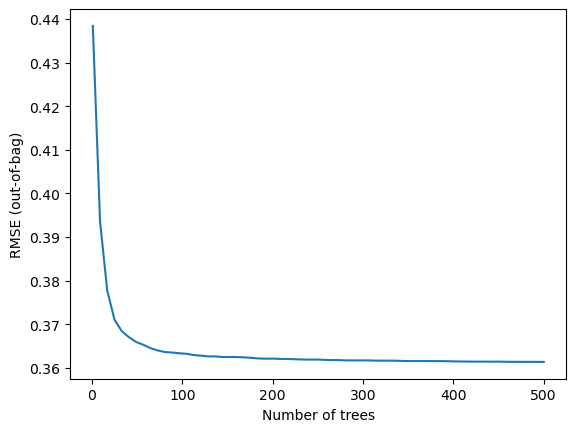

In [25]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [26]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=427794, accuracy=None, loss=None, rmse=0.3613382234071038, ndcg=None, aucs=None, auuc=None, qini=None)

In [27]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

48/48 [==============================] - 11s 218ms/step - loss: 0.0000e+00 - mape: 1.6384
loss: 0.0000
mape: 1.6384


In [28]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [29]:
# inspector.variable_importances()

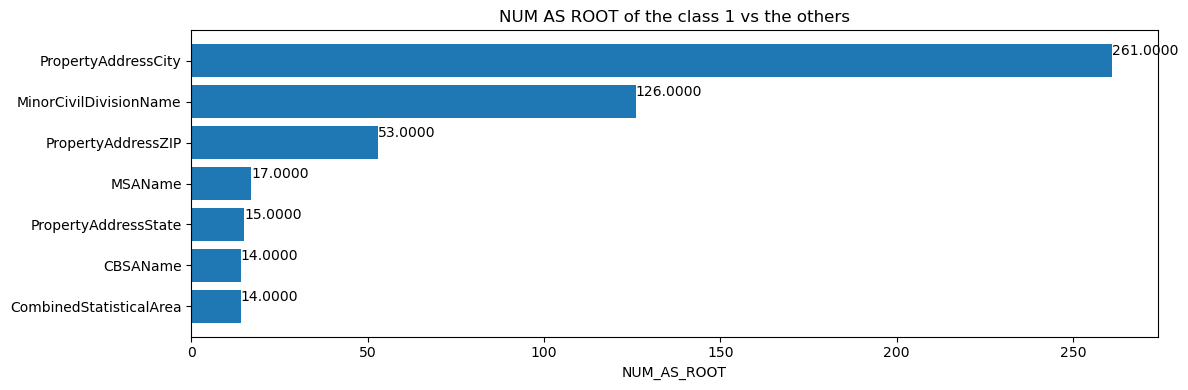

In [30]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [31]:
test_file_path = "test_data.csv"

test_data = pd.read_csv(test_file_path)
test_data['RecordingDate'] = pd.to_datetime(test_data['RecordingDate'])

test_data['RecordMonth'] = test_data['RecordingDate'].map(lambda x: x.month).astype('float64')
test_data['RecordYear'] = test_data['RecordingDate'].map(lambda x: x.year).astype('float64')
# test_data['Year-Month'] = test_data['RecordingDate'].map(lambda x: str(x.year)+"-"+str(x.month))

ids = test_data.pop('RecordID')
test_data = test_data.drop('RecordingDate',axis=1)
# test_data = test_data[vars] #vars.remove('SalePrice')
test_data = test_data.drop(exclude_lst, axis=1)

print(test_data.shape)
test_vars = test_data.columns.values


(32709, 173)


In [32]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

In [33]:
test_data.head(10)

,HouseID,PropertyAddressCity,PropertyAddressState,PropertyAddressZIP,CombinedStatisticalArea,CBSAName,CBSACode,MSAName,MSACode,MetropolitanDivision,...,StableFlag,StorageBuildingArea,StorageBuildingFlag,UtilityBuildingArea,UtilityBuildingFlag,PoleStructureArea,PoleStructureFlag,CommunityRecRoomFlag,RecordMonth,RecordYear
0,334298020,JACKSONVILLE,FL,32220.0,"Jacksonville-St. Marys-Palatka, FL-GA","JACKSONVILLE, FL METROPOLITAN STATISTICAL AREA",27260,"JACKSONVILLE, FL",27260,NaN,...,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,3.0,2023.0
1,334735839,SIMI VALLEY,CA,93065.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0
2,43085369,VENTURA,CA,93003.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0
3,39580261,VENTURA,CA,93003.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0
4,206599569,OXNARD,CA,93036.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0
5,43233754,VENTURA,CA,93001.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0
6,4753801,VENTURA,CA,93003.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0
7,39540764,OXNARD,CA,93035.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0
8,249210048,OXNARD,CA,93036.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0
9,149956382,CAMARILLO,CA,93010.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,"OXNARD-THOUSAND OAKS-VENTURA, CA",37100,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,2023.0


In [34]:
preds = rf.predict(test_ds)
output = pd.DataFrame({'RecordID': ids,
                       'SalePrice': np.exp(preds.squeeze())})

output.head()

33/33 [==============================] - 7s 214ms/step


,RecordID,SalePrice
0,1007014388,342474.59375
1,1005004987,731344.37500
2,1004024173,943176.37500
3,1003744835,541651.62500
4,1003886288,606106.37500


In [35]:
# TODO: build dir, write down parameters of model
output.to_csv('submission_tfdf_masp_log.csv', index=False)